# Setup

In [1]:
import json
import numpy as np
import os
from pathlib import Path
from utilities_network import data_to_array_by_quantity, scale_data_array
from utilities_network import get_time_networks, plot_heatmaps, SYMDICT, SENSOR_DICT
import utilities_visualization

In [2]:
SCALE_DATA = None # 'overall', 'individual', None
DISTANCE = 'recurrence' # 'threshold'
COMPUTE_NEW = False # To compute new networks
PLOT_NEW = True
WINDOW_SIZE = 190
STEP_SIZE = 10

# Data

In [3]:
with open("../../experiments/data_2025-09-03 Euler Angles_20250903_203926.json", 'r') as f:
    data_dict = json.load(f)

if SCALE_DATA == 'overall':
    OUT_DIR = Path("plots/scaled_overall")
elif SCALE_DATA == 'individual':
    OUT_DIR = Path("plots/scaled_individually")
elif SCALE_DATA is None:
    OUT_DIR = Path("plots/no_scaling")

if DISTANCE == 'threshold':
    OUT_DIR = OUT_DIR/"th"
elif DISTANCE == 'recurrence':
    OUT_DIR = OUT_DIR/"rr"

OUT_DIR = OUT_DIR/f"heatmaps_{WINDOW_SIZE}"

if not OUT_DIR.exists():
    os.makedirs(OUT_DIR)

# Plot Network Heatmaps

In [4]:
network_parameters = {
    'w_xy': dict(
        quantities={
            'OR':[['time','wxy']],
            'IB':[['time','wx'], ['time','wy'], ['time','wz']],
            'IT':[['time','wx'], ['time','wy'], ['time','wz']],
            'IL':[['time','wx'], ['time','wy'], ['time','wz']],
        },
        target_node = f"{SYMDICT['wxy']},{SENSOR_DICT['OR']}",
        rr=(0.03,0.03,0.02),
        window_size=WINDOW_SIZE,
        step_size = STEP_SIZE,
    ),
    'psidot': dict(
        quantities={
            'OR':[['time','psidot']],
            'IB':[['time','wx'], ['time','wy'], ['time','wz']],
            'IT':[['time','wx'], ['time','wy'], ['time','wz']],
            'IL':[['time','wx'], ['time','wy'], ['time','wz']],
        },
        target_node = f"{SYMDICT['psidot']},{SENSOR_DICT['OR']}",
        rr=(0.03,0.03,0.02),
        window_size=WINDOW_SIZE,
        step_size = STEP_SIZE,
    ),
}

In [5]:
if COMPUTE_NEW:
    for title,parameters in network_parameters.items():
        quantities = parameters['quantities']

        if SCALE_DATA is None:
            # Don't scale data at all
            data = data_to_array_by_quantity(data_dict,
                                    quantities=quantities)
            
        else:
            # Scale overall if specified; otherwise scale individually
            data = scale_data_array(data_to_array_by_quantity(data_dict,
                                quantities=quantities),
                                scale_overall=(SCALE_DATA=='overall'),
                                )
        network_windows = get_time_networks(data=data,
                                            use_thresholds=(DISTANCE=='threshold'),
                                            rr=parameters['rr'],
                                            window_size=parameters['window_size'],
                                            step_size=parameters['step_size'])
        np.save(OUT_DIR/f"{title}_windows.npy", network_windows)


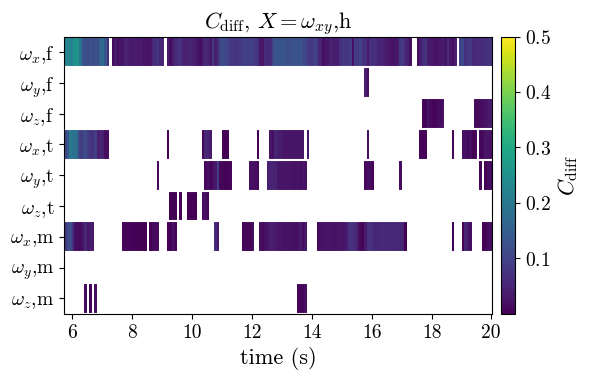

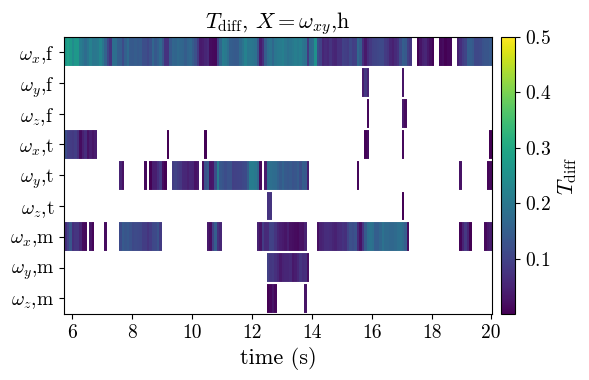

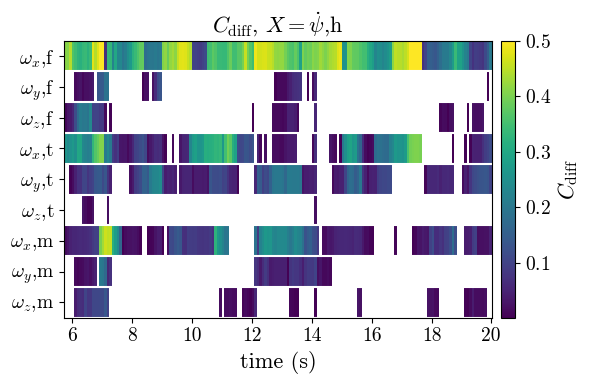

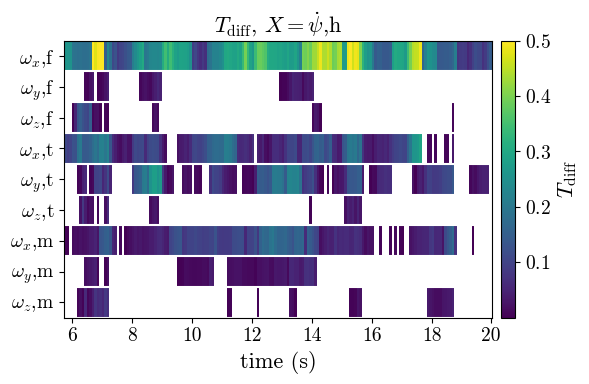

In [6]:
if PLOT_NEW:
    time=data_dict['OR']['time']

    for title,parameters in network_parameters.items():
        quantities = parameters['quantities']
        target_node = parameters['target_node']
        node_labels = [f"{SYMDICT[q[1]]},{SENSOR_DICT[s]}" for s,qsets in quantities.items() for q in qsets]

        network_windows = np.load(OUT_DIR/f"{title}_windows.npy")
        plot_heatmaps(network_windows,
                node_labels,
                target_node,
                time=time,
                heatmap_max=parameters.get('heatmap_max',0.5),
                window_size=parameters['window_size'],
                step_size=parameters['step_size'],
                plot_filename_prefix=OUT_DIR/title)